In [257]:
import requests
from datetime import datetime, timedelta, UTC
import pandas as pd
from io import BytesIO
import json
from collections import defaultdict

session = requests.Session()
url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"

def api_get(path, *args, **kwargs):
    r = session.get(url + path, *args, **kwargs)
    if not r.ok:
        print(f"API Error")
        print(json.dumps(r.json(), indent = 4))
    return r

In [258]:
def sort_by_platform(stations) -> dict[str, list[dict]]:
    by_platform = defaultdict(list)
    for s in stations:
        by_platform[s["platform"]].append(s)
    return by_platform
    
lookback = timedelta(hours = 5) 

all_stations = api_get("stations", params = {
}).json()

recent_stations = api_get("stations", params = {
    "start_time" : datetime.now(UTC) - lookback
}).json()

print("All stations")
all_by_platform = sort_by_platform(all_stations)
print({k : len(v) for k, v in all_by_platform.items()})
print()

print(f"Recent ({lookback})")
print({k : len(v) for k, v in sort_by_platform(recent_stations).items()})
print()

All stations
{'meteotracker': 279, 'acronet': 95, 'smart_citizen_kit': 5}

Recent (5:00:00)
{'acronet': 94, 'meteotracker': 4, 'smart_citizen_kit': 5}



## Total Meteotracker datasets

In [259]:
all_by_platform['meteotracker'][-1]

{'name': 'MeteoTracker Track',
 'description': 'A MeteoTracker Track.',
 'platform': 'meteotracker',
 'external_id': '6762a16fb1a4f304fcb101fd',
 'internal_id': '922b80aaec03e6b6',
 'location': [8.8963808, 44.44004245],
 'time_span': ['2024-12-18T10:18:21.011000Z', '2024-12-18T10:29:13.011000Z'],
 'authors': [{'name': 'meteotracker'}, {'name': 'CIMA I-Change'}],
 'mars_request': {'class': 'rd',
  'expver': 'xxxx',
  'stream': 'lwda',
  'aggregation_type': 'tracked',
  'date': '20241218',
  'platform': 'meteotracker',
  'internal_id': '922b80aaec03e6b6'}}

In [260]:
dates = [datetime.fromisoformat(s['time_span'][1]) for s in all_by_platform['meteotracker']]
earliest, latest = min(dates), max(dates)
print(f"Meteotracker: {len(all_by_platform['meteotracker'])} tracks.")
print(f"Earliest ingested data: {earliest}")
print(f"Most recent ingested data: {latest}")

Meteotracker: 279 tracks.
Earliest ingested data: 2024-11-28 16:53:23+00:00
Most recent ingested data: 2024-12-18 10:29:13.011000+00:00


## Total Acronet datasets

In [261]:
def get_all_granules_by_platform(platform):
    granules = api_get("list", params = {'platform': platform}).json()
    dates = [datetime.fromisoformat(d["datetime"]) for d in granules]
    assert all(g["mars_request"]["platform"] == platform for g in granules)
    return granules, dates

acronet_granules, dates = get_all_granules_by_platform(platform = "acronet")
earliest, latest = min(dates), max(dates)
total_time = timedelta(minutes = 5) * len(acronet_granules)

print(f"Acronet: {len(all_by_platform['acronet'])} distinct stations.")
print(f"Earliest ingested data: {earliest} Most recent ingested data: {latest}")
print(f"Ingested data: {len(acronet_granules)} 5 minute acronet data granules.")
print(f"Total time: {total_time}")

Acronet: 95 distinct stations.
Earliest ingested data: 2024-12-11 15:45:00+00:00 Most recent ingested data: 2024-12-16 18:15:00+00:00
Ingested data: 5152 5 minute acronet data granules.
Total time: 17 days, 21:20:00


## Total Smart Citizen Kit Datasets

In [262]:
sck_granules, dates = get_all_granules_by_platform(platform = "smart_citizen_kit")
earliest, latest = min(dates), max(dates)
total_time = timedelta(minutes = 5) * len(sck_granules)

print(f"Smart Citizen Kit: {len(all_by_platform['smart_citizen_kit'])} distinct stations.")
print(f"Earliest ingested data: {earliest} Most recent ingested data: {latest}")
print(f"Ingested data: {len(sck_granules)} 5 minute sck data granules.")
print(f"Total time: {total_time}")

Smart Citizen Kit: 5 distinct stations.
Earliest ingested data: 2024-12-16 16:25:00+00:00 Most recent ingested data: 2024-12-18 12:25:00+00:00
Ingested data: 2496 5 minute sck data granules.
Total time: 8 days, 16:00:00


## Retrieving chunked data for continuous data streams
Acronet, Smart Citizen Kit

Latest data: 2024-12-18 09:05:00+00:00


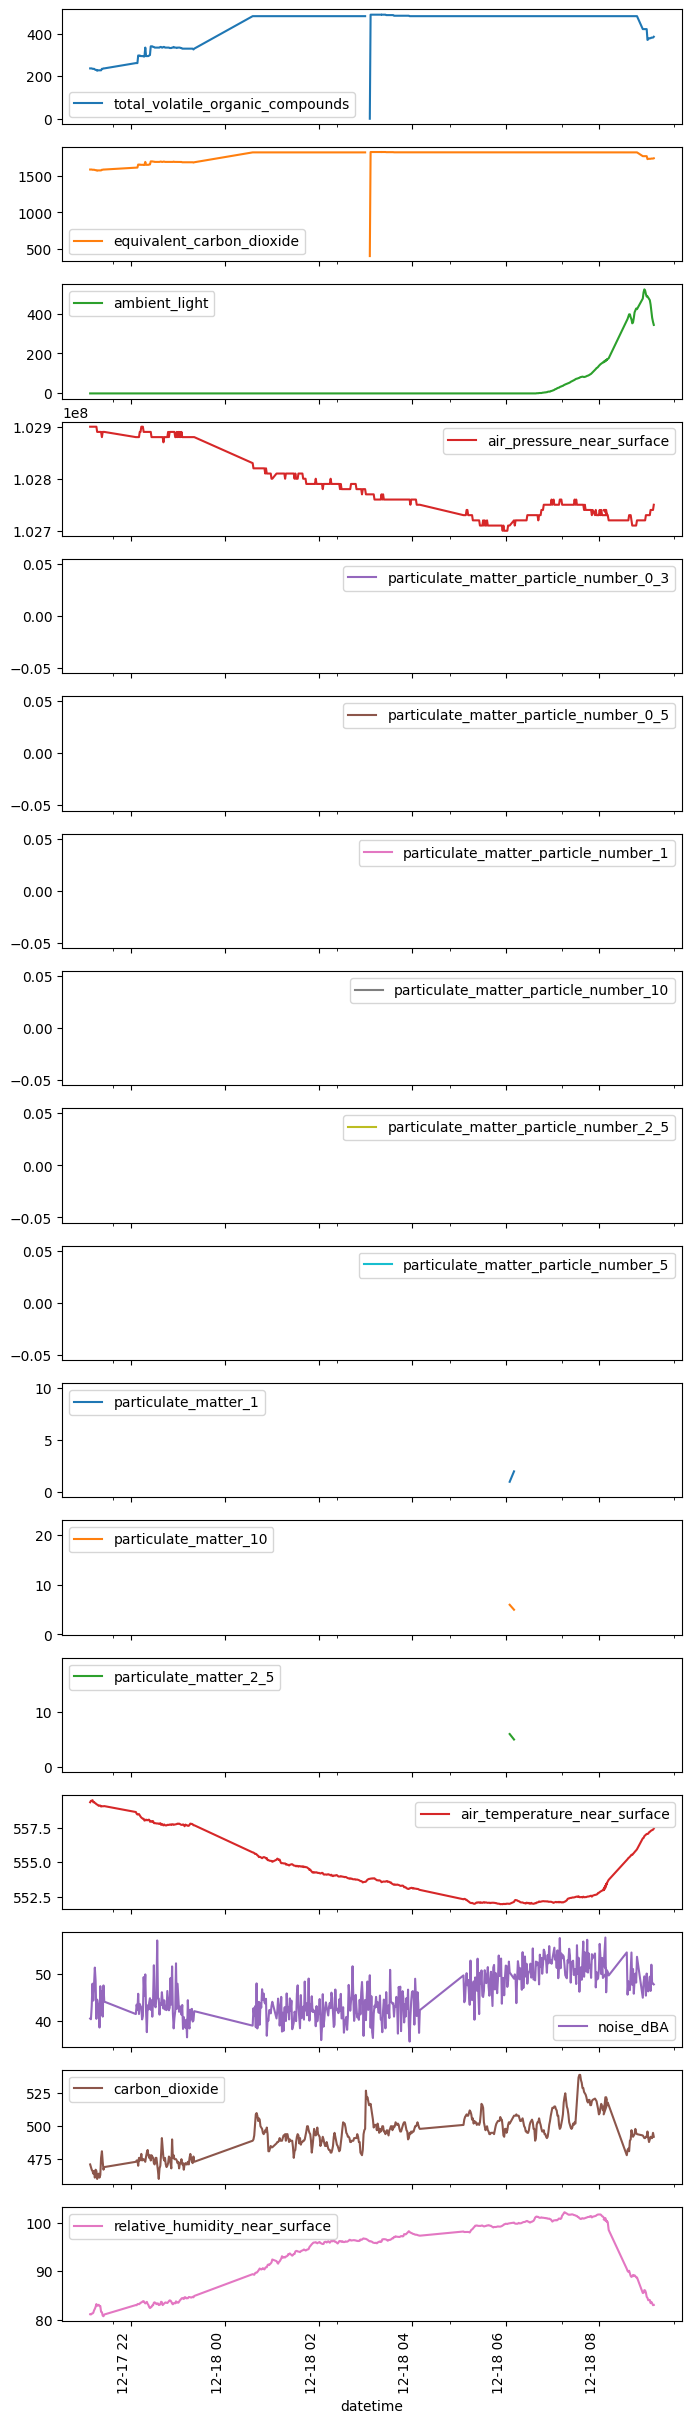

In [263]:
def plot_example_station(station):
    latest = datetime.fromisoformat(example_station["time_span"][1])
    print(f"Latest data: {latest}")
    args = {
        "start_time" : (latest - timedelta(hours = 12)).isoformat(),
        "end_time": latest.isoformat(),
    }
    
    data = api_get("retrieve", params = example_station["mars_request"] | args | dict(format = "csv"))
    df = pd.read_csv(BytesIO(data.content))
    
    df["datetime"] = pd.to_datetime(df["datetime"])
    exclude_columns = {"external_id", "date", "lat", "lon", "altitude"}
    numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) 
                       if (dtype == "float64" or dtype == "int64")
                       and col not in exclude_columns]
    
    axes = df.plot(
        x = "datetime",
        y = numeric_columns,
        subplots=True, layout=(len(numeric_columns), 1), figsize=(8, 2*len(numeric_columns)), sharex=True, rot=90)

example_station = by_platform["smart_citizen_kit"][-1]
plot_example_station(example_station)

## Retrieve and plot a Meteotracker track

In [264]:
example_station = by_platform["meteotracker"][-1]

print(json.dumps(example_station["mars_request"], indent = 4))
granule_list = api_get("list", params = example_station["mars_request"]).json()

print(f"The above MARS request matches {len(granule_list)} data granule(s).")

# Sanity check
assert len(granule_list) == 1

args = {
    "format" : "json"
}

{
    "class": "rd",
    "expver": "xxxx",
    "stream": "lwda",
    "aggregation_type": "tracked",
    "date": "20241218",
    "platform": "meteotracker",
    "internal_id": "3f164abf6ac07741"
}
The above MARS request matches 1 data granule(s).


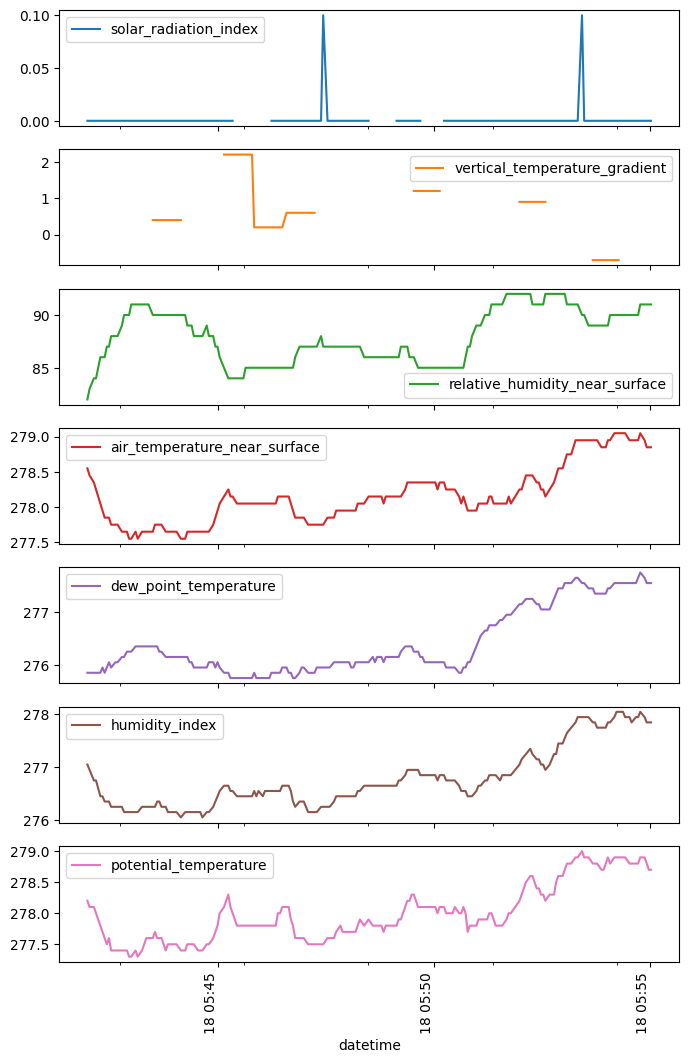

In [265]:
data = api_get("retrieve", params = example_station["mars_request"] | args)
df = pd.DataFrame.from_records(data.json())
df["datetime"] = pd.to_datetime(df["datetime"])

exclude_columns = {"external_id", "date", "lat", "lon", "altitude"}
numeric_columns = [col for col, dtype in zip(df.columns, df.dtypes) 
                   if (dtype == "float64" or dtype == "int64")
                   and col not in exclude_columns]

axes = df.plot(
    x = "datetime",
    y = numeric_columns,
    subplots=True, layout=(len(numeric_columns), 1), figsize=(8, 2*len(numeric_columns)), sharex=True, rot=90)


In [266]:
import geopandas as gpd
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)
geo_df.explore(column = "altitude")